# Animate concentrations along cross section

In [15]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import cmocean
from math import sin, cos, sqrt, atan2, radians
import xarray as xr
import imageio
from datetime import datetime
import glob

%matplotlib inline

#### Parameters

In [16]:
# domain dimensions:
imin, imax = 1139, 2179
jmin, jmax = 159, 799

# transect coordinates:
BB_coords = (1470,1471,515,670) # Baffin Bay
DS_coords = (1320,1321,538,630) # Davis Strait (jet)

In [17]:
# Colors
land_color = '#a9a7a2'
light_gray = '#b1b1b1'
light_land = '#d0d0cf'
land_edge  = '#929291'

#### Files

In [18]:
mesh         = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20230213.nc')
mesh_lon     = np.array(mesh.variables['nav_lon'])
mesh_lat     = np.array(mesh.variables['nav_lat'])
mesh_bathy   = np.array(mesh.variables['tmask'][0,:,:,:])
mesh_bathyV  = np.array(mesh.variables['vmask'][0,:,:,:])
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
bathy_maskedV = np.ma.masked_where((mesh_bathyV> 0.1), mesh_bathyV)
ocean_masked = np.ma.masked_where((mesh_bathy<0.1), mesh_bathy)
depths       = np.array(mesh.variables['nav_lev'])

In [19]:
# transect coordinates
BB_lons = mesh_lon[BB_coords[0]:BB_coords[1],BB_coords[2]:BB_coords[3]][0,:]
BB_lats = mesh_lat[BB_coords[0]:BB_coords[1],BB_coords[2]:BB_coords[3]][0,:]
BB_deps = bathy_masked[:,BB_coords[0]:BB_coords[1],BB_coords[2]:BB_coords[3]][:,0,:]

In [20]:
# transect coordinates
DS_lons  = mesh_lon[DS_coords[0]:DS_coords[1],DS_coords[2]:DS_coords[3]][0,:]
DS_lats  = mesh_lat[DS_coords[0]:DS_coords[1],DS_coords[2]:DS_coords[3]][0,:]
DS_deps  = bathy_masked[:,DS_coords[0]:DS_coords[1],DS_coords[2]:DS_coords[3]][:,0,:]
DS_depsV = bathy_maskedV[:,DS_coords[0]:DS_coords[1],DS_coords[2]:DS_coords[3]][:,0,:]

In [21]:
years  = np.arange(2010,2020,1) 
files1 = []; files2 = []; files3 = [];
for year in years:
    folder1 = f'/data/brogalla/run_storage/Pb-reference-202303/Pb-reference-{year}_20230308/'
    folder2 = f'/data/brogalla/run_storage/Pb-reference-202303/Pb-Labrador-Sea-{year}_20230308/'
        
    files1 = np.append(files1, np.sort(glob.glob(f'{folder1}/ANHA12_EXH006_5d_*')))
    files2 = np.append(files2, np.sort(glob.glob(f'{folder2}/ANHA12_EXH006_5d_*')))
    files3 = np.append(files3, np.sort(glob.glob(f'/data/brogalla/ANHA12/ANHA12-EXH006_y{year}m??d??_gridV.nc')))
    
dates1 = [file.split('ptrc_T_')[1][0:-3] for file in files1]
dates2 = [file.split('ptrc_T_')[1][0:-3] for file in files2]
dates3 = [file.split('_')[1][0:11] for file in files3]

#### Functions

In [22]:
# Convert lat/lon to distance along transect:
def calc_distance(lats, lons):
    R = 6373.0 # approximate radius of earth in km

    lats_rad = [radians(l) for l in lats]
    lons_rad = [radians(l) for l in lons]

    dlon = [lon_step - lons_rad[0] for lon_step in lons_rad]
    dlat = [lat_step - lats_rad[0] for lat_step in lats_rad]

    distance = np.empty((len(dlon)))
    for i in range(0,len(dlon)):
        a = sin(dlat[i] / 2)**2 + cos(lats_rad[0]) * cos(lats_rad[i]) * sin(dlon[i] / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance[i] = R * c
        
    return distance

In [23]:
def plot_cross_section(file1, n, coords, distance, deps, vmin=0, vmax=30, ylim=(2600,-10)):
    
    with xr.open_dataset(f'{file1}') as f:
        f1 = f['dissolpb'].values[0,:,coords[0]-imin:coords[1]-imin,coords[2]-jmin:coords[3]-jmin][:,0,:]
        
    fig, ax = plt.subplots(1,1, figsize=(4.5, 3.7*0.8), dpi=300)

    ax.set_xlabel('Distance [km]', fontsize=7)
    ax.set_ylabel('Depth [m]', fontsize=7)
    ax.invert_yaxis()
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.set_ylim(ylim[0],ylim[1])

    # Cross-section
    xx, zz = np.meshgrid(distance, depths)
    CB1 = ax.pcolormesh(xx, zz, f1*1e12, vmin=vmin, vmax=vmax, cmap=cmocean.cm.matter)
    ax.pcolormesh(xx, zz, deps, cmap=matplotlib.colors.ListedColormap([land_color]))

    cbax1 = fig.add_axes([0.75, 0.2, 0.04, 0.3]);
    CBar  = plt.colorbar(CB1, ax=ax, cax=cbax1, ticks=[0,5,10,15,20]); 
    CBar.set_label('Dissolved Pb [pM]', fontsize=7)
    CBar.ax.tick_params(axis='y', length=0, labelsize=6)
   
    ax.set_title(datetime.strptime(dates1[n][0:8],"%Y%M%d").strftime('%Y-%M-%d'), fontsize=6)
    return fig

In [24]:
def plot_cross_section_Atlantic(file1, file2, n, coords, distance, deps, vmin=0, vmax=30, ylim=(2600,-10)):
    
    with xr.open_dataset(f'{file1}') as f:
        f1 = f['dissolpb'].values[0,:,coords[0]-imin:coords[1]-imin,coords[2]-jmin:coords[3]-jmin][:,0,:]
    with xr.open_dataset(f'{file2}') as f:
        f2 = f['dissolpb'].values[0,:,coords[0]-imin:coords[1]-imin,coords[2]-jmin:coords[3]-jmin][:,0,:]
    
    fig, ax = plt.subplots(1,1, figsize=(4.5, 3.7*0.8), dpi=300)

    ax.set_xlabel('Distance [km]', fontsize=7)
    ax.set_ylabel('Depth [m]', fontsize=7)
    ax.invert_yaxis()
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.set_ylim(ylim[0],ylim[1])

    # Cross-section
    xx, zz = np.meshgrid(distance, depths)
    CB1 = ax.pcolormesh(xx, zz, (f2-f1)*1e12, vmin=vmin, vmax=vmax, cmap=cmocean.cm.rain)
    ax.pcolormesh(xx, zz, deps, cmap=matplotlib.colors.ListedColormap([land_color]))

    cbax1 = fig.add_axes([0.75, 0.2, 0.04, 0.3]);
    CBar  = plt.colorbar(CB1, ax=ax, cax=cbax1, ticks=[0,1,2,3,4]); 
    CBar.set_label(r'$\Delta$ Dissolved Pb [pM]', fontsize=7)
    CBar.ax.tick_params(axis='y', length=0, labelsize=6)

    ax.set_title(datetime.strptime(dates1[n][0:8],"%Y%M%d").strftime('%Y-%M-%d'), fontsize=6)
    
    return fig

In [25]:
def plot_cross_section_V(file1, n, coords, distance, deps, vmin=0, vmax=30, ylim=(1500,-5)):
    
    with xr.open_dataset(f'{file1}') as f:
        f1 = f['vomecrty'].values[0,:,coords[0]:coords[1],coords[2]:coords[3]][:,0,:]
        
    fig, ax = plt.subplots(1,1, figsize=(4.5, 3.7*0.8), dpi=300)

    ax.set_xlabel('Distance [km]', fontsize=7)
    ax.set_ylabel('Depth [m]', fontsize=7)
    ax.invert_yaxis()
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.set_ylim(ylim[0],ylim[1])

    # Cross-section
    xx, zz = np.meshgrid(distance, depths)
    CB1 = ax.pcolormesh(xx, zz, f1, vmin=vmin, vmax=vmax, cmap=cmocean.cm.balance)
    ax.pcolormesh(xx, zz, deps, cmap=matplotlib.colors.ListedColormap([land_color]))

    cbax1 = fig.add_axes([0.75, 0.2, 0.04, 0.35]);
    CBar  = plt.colorbar(CB1, ax=ax, cax=cbax1, ticks=[-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3]); 
    CBar.set_label('Meridional velocity [m/s]', fontsize=7)
    CBar.ax.tick_params(axis='y', length=0, labelsize=6)
   
    ax.set_title(datetime.strptime(dates3[n],"y%Ym%Md%d").strftime('%Y-%M-%d'), fontsize=6)
    return fig

#### Calculations

In [26]:
BB_distance  = calc_distance(BB_lats, BB_lons)   
DS_distance  = calc_distance(DS_lats, DS_lons)   

Davis Strait: V velocity

In [13]:
for n, date in enumerate(dates3):
    fig = plot_cross_section_V(files3[n], n, DS_coords, DS_distance, DS_depsV, vmin=-0.3, vmax=0.3, ylim=(1500,-5))
    fig.savefig(f'/ocean/brogalla/GEOTRACES/figures/Pb/animation/Davis-Strait-cross-section-V-{date}.png', 
                dpi=300)
    plt.close(fig)

In [28]:
filenames = np.sort(glob.glob(f'/ocean/brogalla/GEOTRACES/figures/Pb/animation/Davis-Strait-cross-section-V*'))
with imageio.get_writer(f'/ocean/brogalla/GEOTRACES/figures/Pb/animation/Davis-Strait-cross-section-V-velocity.mp4', 
                        macro_block_size = None, fps=7, mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

#### Figures

Text(0.5, 1.0, '2019-12-27')

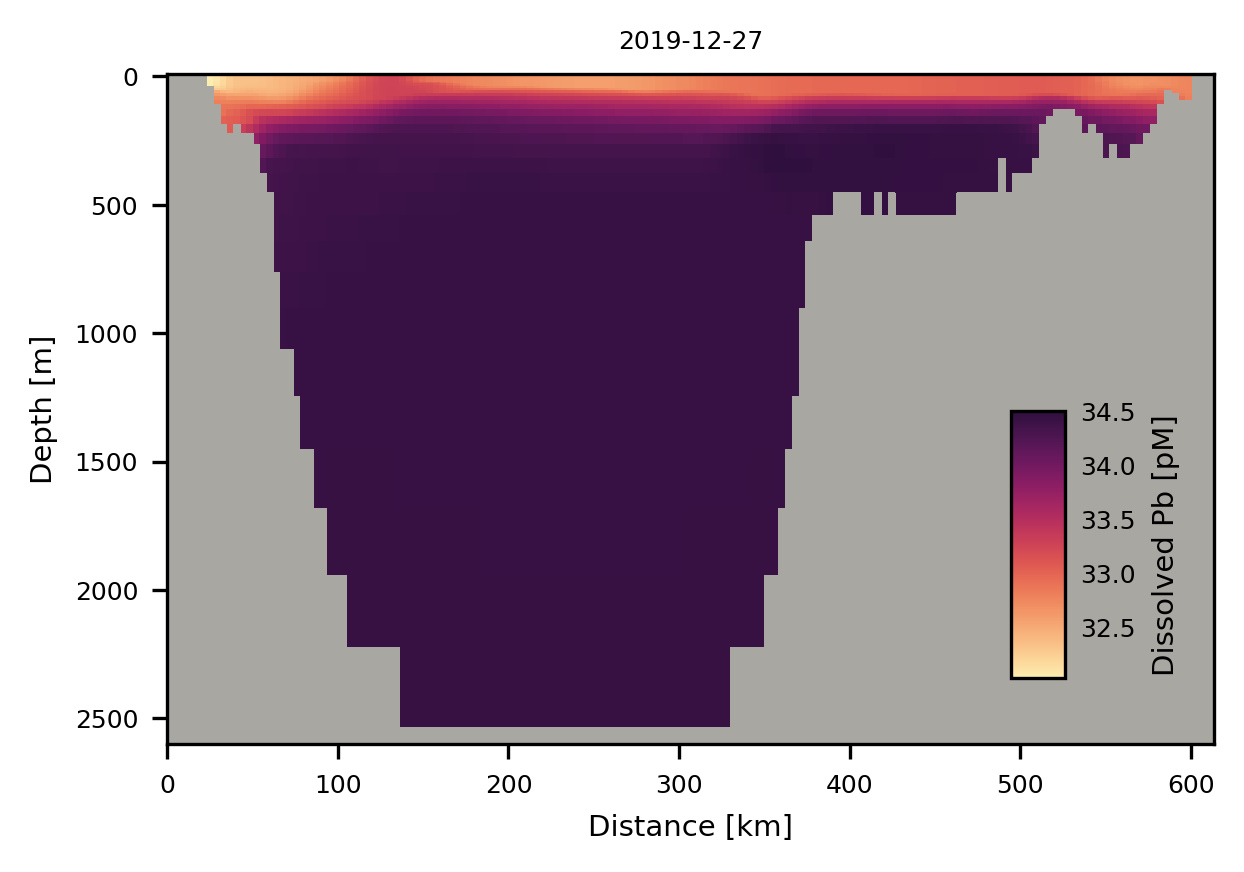

In [24]:
f = xr.open_dataset('/data/brogalla/ANHA12/ANHA12-EXH006_5d_gridT_y2008m01d30.nc')
f1 = f['vosaline'].values[0,:,BB_coords[0]:BB_coords[1],BB_coords[2]:BB_coords[3]][:,0,:]
        
fig, ax = plt.subplots(1,1, figsize=(4.5, 3.7*0.8), dpi=300)

ax.set_xlabel('Distance [km]', fontsize=7)
ax.set_ylabel('Depth [m]', fontsize=7)
ax.invert_yaxis()
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(2600,-10)

# Cross-section
xx, zz = np.meshgrid(BB_distance, depths)
CB1 = ax.pcolormesh(xx, zz, f1, cmap=cmocean.cm.matter)
ax.pcolormesh(xx, zz, BB_deps, cmap=matplotlib.colors.ListedColormap([land_color]))

cbax1 = fig.add_axes([0.75, 0.2, 0.04, 0.3]);
CBar  = plt.colorbar(CB1, ax=ax, cax=cbax1); 
CBar.set_label('Dissolved Pb [pM]', fontsize=7)
CBar.ax.tick_params(axis='y', length=0, labelsize=6)
   
ax.set_title(datetime.strptime(dates1[n][0:8],"%Y%M%d").strftime('%Y-%M-%d'), fontsize=6)

Text(0.5, 1.0, '2019-12-27')

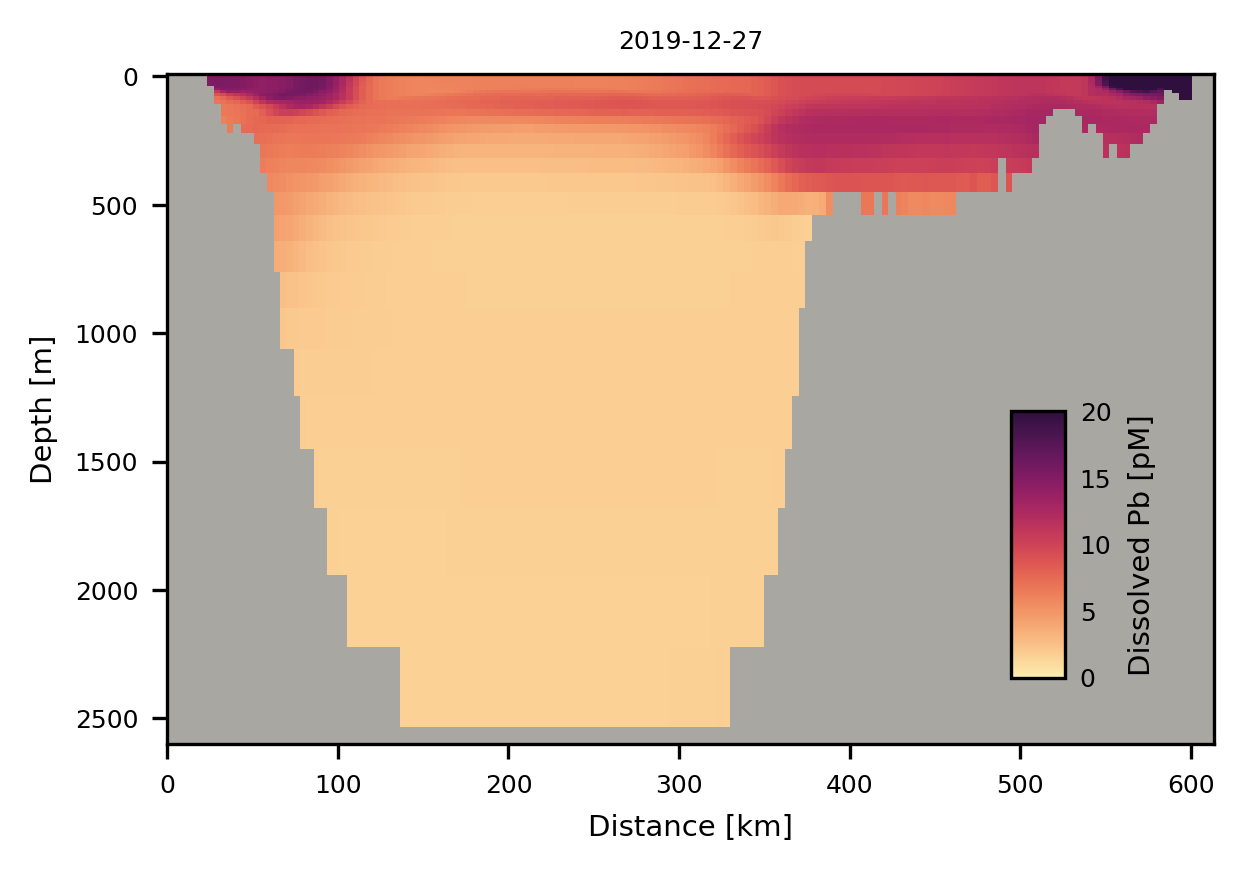

In [20]:
f = xr.open_dataset('/data/brogalla/run_storage/Pb-reference-202303/Pb-reference-2008_20230308/'+
                    'ANHA12_EXH006_5d_20080101_20081231_ptrc_T_20080126-20080130.nc')
f1 = f['dissolpb'].values[0,:,BB_coords[0]-imin:BB_coords[1]-imin,BB_coords[2]-jmin:BB_coords[3]-jmin][:,0,:]
        
fig, ax = plt.subplots(1,1, figsize=(4.5, 3.7*0.8), dpi=300)

ax.set_xlabel('Distance [km]', fontsize=7)
ax.set_ylabel('Depth [m]', fontsize=7)
ax.invert_yaxis()
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(2600,-10)

# Cross-section
xx, zz = np.meshgrid(BB_distance, depths)
CB1 = ax.pcolormesh(xx, zz, f1*1e12, vmin=0, vmax=20, cmap=cmocean.cm.matter)
ax.pcolormesh(xx, zz, BB_deps, cmap=matplotlib.colors.ListedColormap([land_color]))

cbax1 = fig.add_axes([0.75, 0.2, 0.04, 0.3]);
CBar  = plt.colorbar(CB1, ax=ax, cax=cbax1, ticks=[0,5,10,15,20]); 
CBar.set_label('Dissolved Pb [pM]', fontsize=7)
CBar.ax.tick_params(axis='y', length=0, labelsize=6)
   
ax.set_title(datetime.strptime(dates1[n][0:8],"%Y%M%d").strftime('%Y-%M-%d'), fontsize=6)

Davis Strait:

In [12]:
for n, date in enumerate(dates1):
    fig = plot_cross_section_Atlantic(files1[n], files2[n], n, DS_coords, DS_distance, DS_deps, vmin=0, vmax=4, ylim=(1500,-5))
    fig.savefig(f'/ocean/brogalla/GEOTRACES/figures/Pb/animation/Davis-Strait-cross-section-Atlantic-{date[0:8]}.png', 
                dpi=300)
    plt.close(fig)

In [13]:
filenames = np.sort(glob.glob(f'/ocean/brogalla/GEOTRACES/figures/Pb/animation/Davis-Strait-cross-section-Atlantic*'))
with imageio.get_writer(f'/ocean/brogalla/GEOTRACES/figures/Pb/animation/Davis-Strait-cross-section-Atlantic.mp4', 
                        macro_block_size = None, fps=7, mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

Baffin Bay:

In [11]:
for n, date in enumerate(dates1):
    fig = plot_cross_section_Atlantic(files1[n], files2[n], n, vmin=0, vmax=1.5)
    fig.savefig(f'/ocean/brogalla/GEOTRACES/figures/Pb/animation/Baffin-Bay-cross-section-Atlantic-{date[0:8]}.png', 
                dpi=300)
    plt.close(fig)

In [12]:
filenames = np.sort(glob.glob(f'/ocean/brogalla/GEOTRACES/figures/Pb/animation/Baffin-Bay-cross-section-Atlantic*'))
with imageio.get_writer(f'/ocean/brogalla/GEOTRACES/figures/Pb/animation/Baffin-Bay-cross-section-Atlantic.mp4', 
                        macro_block_size = None, fps=7, mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

In [74]:
for n, date in enumerate(dates1):
    fig = plot_cross_section(files1[n], n, vmin=0, vmax=20)
    fig.savefig(f'/ocean/brogalla/GEOTRACES/figures/Pb/animation/Baffin-Bay-cross-section-{date[0:8]}.png', dpi=300)
    plt.close(fig)

In [75]:
filenames = np.sort(glob.glob(f'/ocean/brogalla/GEOTRACES/figures/Pb/animation/Baffin-Bay-cross-section-*'))
with imageio.get_writer(f'/ocean/brogalla/GEOTRACES/figures/Pb/animation/Baffin-Bay-cross-section.mp4', 
                        macro_block_size = None, fps=7, mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)